# San Francisco Crime Classification
## Type: Multiclass Classification

# Getting the CSV train file

In [1]:
import pandas as pd
csv = pd.read_csv('files/train.csv')
csv

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541
...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607


# Inspecting the CSV

In [2]:
csv.shape

(878049, 9)

In [3]:
print(len(csv['Category'].unique()))
csv.isna().sum() # Verify for nan values

39


Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

# Transforming the data

In [4]:
df = csv

df.Dates = pd.to_datetime(df.Dates)
df.Dates = df.Dates.apply(lambda x: x.timestamp())

df.Category, unique = pd.factorize(df.Category)
df.Category = df.Category.astype(float)

df.Descript, unique = pd.factorize(df.Descript)
df.Descript = df.Descript.astype(float)

df.DayOfWeek, unique = pd.factorize(df.DayOfWeek)
df.DayOfWeek = df.DayOfWeek.astype(float)

df.PdDistrict, unique = pd.factorize(df.PdDistrict)
df.PdDistrict = df.PdDistrict.astype(float)

df.Resolution, unique = pd.factorize(df.Resolution)
df.Resolution = df.Resolution.astype(float)

category = df.Category
df = df.drop(columns=['Address', 'Descript', 'Resolution', 'Category', 'X', 'Y'])


 # Splitting & Scaling the data

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x_df = df
y_df = category

X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(data=X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(data=X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(data=y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(data=y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

# Creating the Multiclass Model

In [7]:
import torch.nn as nn

class CrimeClassificationModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(CrimeClassificationModel, self).__init__()
        self.hd1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(64) # Help for learn faster
        self.hd2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.hd5 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.hd1(x))
        x = self.relu(self.hd2(x))
        return self.hd5(x)

In [8]:
from torch import optim

input_size: int = X_train.shape[1]
output_size: int = len(y_df.unique())

model = CrimeClassificationModel(input_size=input_size, output_size=output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
input_size

3

# Train & Test function

In [10]:
def train(model, train_loader, optimizer, criterion, epochs):
    loss_list = []
    epoch_list = []
    data = {}
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        list = []
        
        for index, (batch_x, batch_y) in enumerate(train_loader):            
            optimizer.zero_grad()
            output = model(batch_x)
            
            loss = criterion(output, batch_y)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            list.append(loss.item())
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs}, Loss mean: {epoch_loss:.4f}')
        
        data[epoch + 1] = list
        
        loss_list.append(epoch_loss)
        epoch_list.append(epoch)
    
    return loss_list, epoch_list, data

In [11]:
def test(model, test_loader, criterion):
    model.eval()
    loss_list = []
    iteration_list = []
    
    for index, (batch_x, batch_y) in enumerate(test_loader):
        output = model(batch_x)
        loss = criterion(output, batch_y)
        
        print('Index {:d} Loss mean: {:.4f}'.format(index, loss.item()))
        
        loss_list.append(loss.item())
        iteration_list.append(index)
    
    return loss_list, iteration_list

# Training & testing the model: Target Category Column

In [12]:
epochs = 100

In [13]:
loss_list, epoch_list, data = train(model=model, train_loader=train_loader, optimizer=optimizer, criterion=criterion, epochs=epochs)

Epoch 0/100, Loss mean: 14478.0191
Epoch 10/100, Loss mean: 14224.2147
Epoch 20/100, Loss mean: 14212.8238
Epoch 30/100, Loss mean: 14207.5329
Epoch 40/100, Loss mean: 14204.5466
Epoch 50/100, Loss mean: 14202.1128
Epoch 60/100, Loss mean: 14200.8535
Epoch 70/100, Loss mean: 14199.6122
Epoch 80/100, Loss mean: 14198.7032
Epoch 90/100, Loss mean: 14198.2777


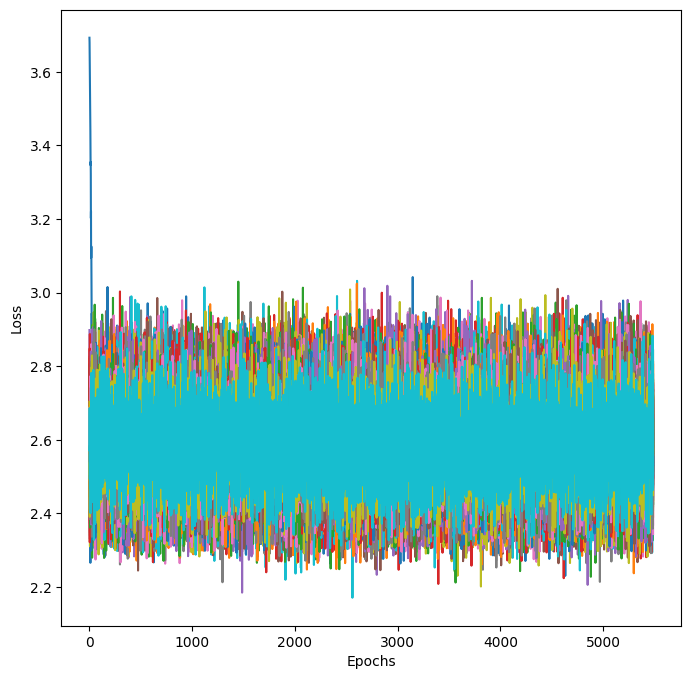

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

for key, values in data.items():
    plt.plot(values, label=f'key {key}')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

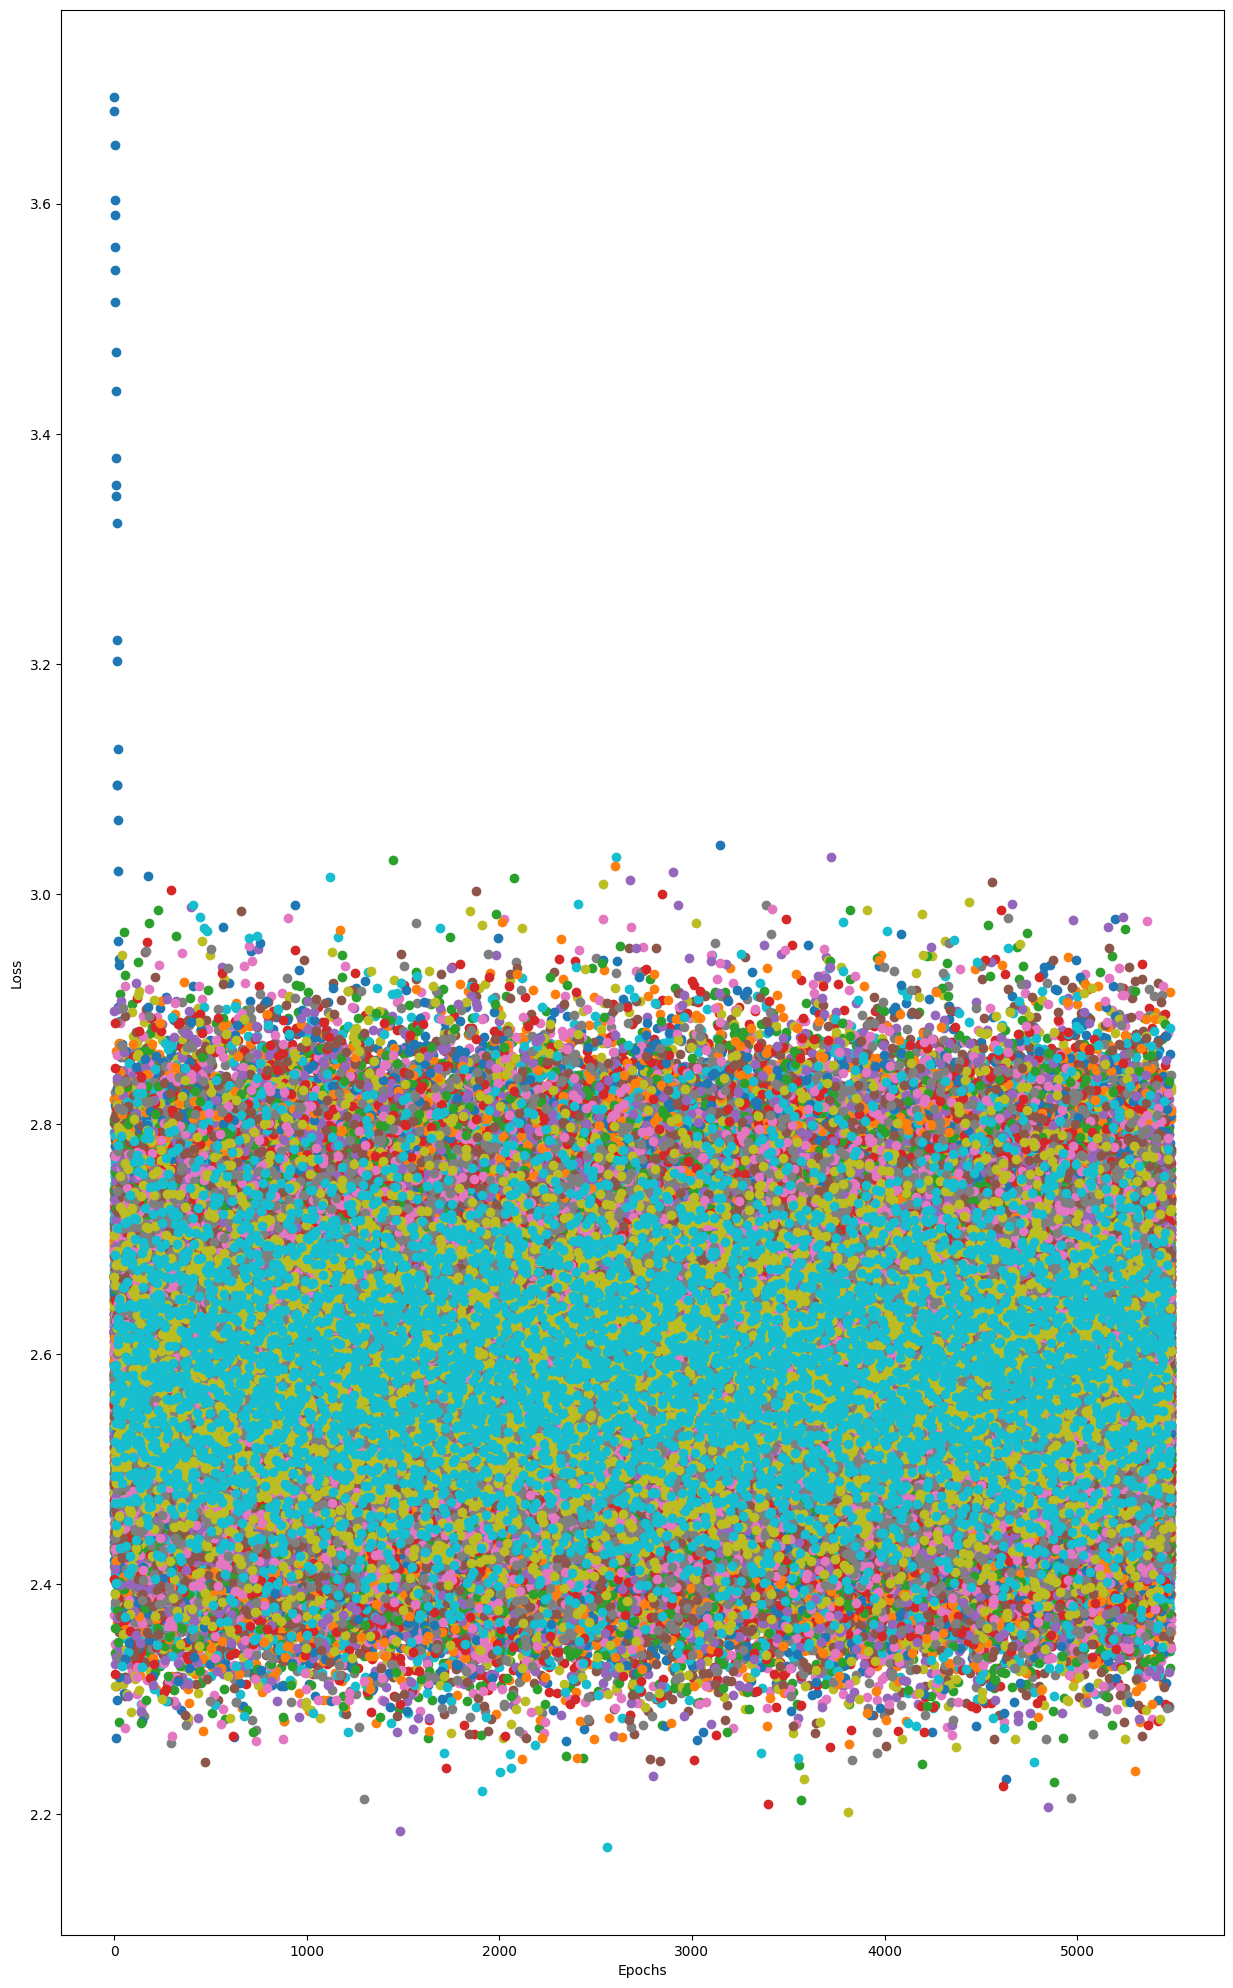

In [15]:
plt.figure(figsize=(15, 25))

for key, values in data.items():
    x_values = list(range(len(values)))
    plt.scatter(x_values, values, label=f'key {key}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.show()

In [16]:
loss_list, iteration_list = test(model=model, test_loader=test_loader, criterion=criterion)

Index 0 Loss mean: 2.4498
Index 1 Loss mean: 2.6324
Index 2 Loss mean: 2.4376
Index 3 Loss mean: 2.6335
Index 4 Loss mean: 2.5959
Index 5 Loss mean: 2.5794
Index 6 Loss mean: 2.6034
Index 7 Loss mean: 2.5933
Index 8 Loss mean: 2.7322
Index 9 Loss mean: 2.4488
Index 10 Loss mean: 2.6589
Index 11 Loss mean: 2.5632
Index 12 Loss mean: 2.7870
Index 13 Loss mean: 2.5503
Index 14 Loss mean: 2.6994
Index 15 Loss mean: 2.7024
Index 16 Loss mean: 2.5838
Index 17 Loss mean: 2.5311
Index 18 Loss mean: 2.6701
Index 19 Loss mean: 2.5172
Index 20 Loss mean: 2.6067
Index 21 Loss mean: 2.5679
Index 22 Loss mean: 2.5911
Index 23 Loss mean: 2.4737
Index 24 Loss mean: 2.6496
Index 25 Loss mean: 2.5448
Index 26 Loss mean: 2.6408
Index 27 Loss mean: 2.5711
Index 28 Loss mean: 2.4974
Index 29 Loss mean: 2.6370
Index 30 Loss mean: 2.5736
Index 31 Loss mean: 2.6448
Index 32 Loss mean: 2.4289
Index 33 Loss mean: 2.4722
Index 34 Loss mean: 2.5630
Index 35 Loss mean: 2.5918
Index 36 Loss mean: 2.6233
Index 37 Lo

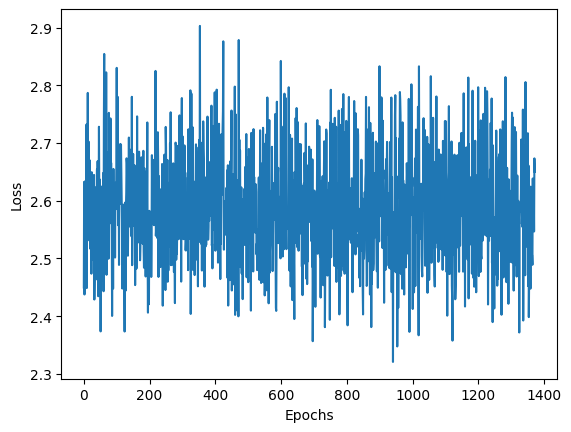

In [17]:
plt.plot(iteration_list, loss_list)

plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.show()

# Save the model into project

In [18]:
torch.save(model, 'models/models.pt')

# Testing the model
## Using the CSV file testing

In [19]:
test = pd.read_csv('files/test.csv')

test.isna().sum()

Id            0
Dates         0
DayOfWeek     0
PdDistrict    0
Address       0
X             0
Y             0
dtype: int64

In [20]:
id = test['Id']
test = test.drop(columns=['Id', 'Address', 'X', 'Y'])

test.Dates = pd.to_datetime(test.Dates)
test.Dates = test.Dates.apply(lambda x: x.timestamp())

test.DayOfWeek, unique = pd.factorize(test.DayOfWeek)
test.DayOfWeek = test.DayOfWeek.astype(float)

test.PdDistrict, unique = pd.factorize(test.PdDistrict)
test.PdDistrict = test.PdDistrict.astype(float)

In [21]:
test = scaler.transform(test)
test_tensor = torch.tensor(data=test, dtype=torch.float32)

In [22]:
model.eval()
predictions = model(test_tensor)

_, predicted = torch.max(predictions.data, 1)
predicted

tensor([2, 2, 2,  ..., 3, 2, 1])

In [23]:
predicted = predicted.numpy().flatten()

result = pd.DataFrame({
    'Id': id,
    'Predicted': predicted
})

In [24]:
result.to_csv('files/result.csv', index=False)